In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import matplotlib.pyplot as plt

import arff

In [2]:
solvent_data = pd.read_excel('/Users/jlisd/Downloads/AI Chem/AI Chem/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'solvent')
solvent_data.set_index('solvent_name', inplace = True)
solvent_columns = list(solvent_data.columns)

In [3]:
solvent_data.shape

(12, 160)

In [4]:
nucleophile_data = pd.read_excel('/Users/jlisd/Downloads/AI Chem/AI Chem/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'nucleophiles')
nucleophile_data.set_index('nucleophile_name', inplace = True)
nucleophile_columns = list(nucleophile_data.columns)

In [5]:
raw_catalyst_data = pd.read_excel('/Users/jlisd/Downloads/AI Chem/AI Chem/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'full_catalyst')
raw_catalyst_data.rename(columns = {'last catalyst only S used': 'catalyst_name'}, inplace = True)

#Taking care of catalyst R/S
r_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    r_catalyst_data.iloc[i, 1] = r_catalyst_data.iloc[i, 1].replace('R/S', 'R')
    #print(r_catalyst_data.iloc[i, 1])
r_catalyst_data.drop(17, inplace = True)    

s_catalyst_data = raw_catalyst_data.copy()
for i in range(17):
    s_catalyst_data.iloc[i, 1] = s_catalyst_data.iloc[i, 1].replace('R/S', 'S')
    #print(s_catalyst_data.iloc[i, 1])
    
catalyst_data = pd.concat([r_catalyst_data, s_catalyst_data])
catalyst_data.set_index('catalyst_name', inplace = True)
catalyst_columns = list(catalyst_data.columns)

In [6]:
iminium_data = pd.read_excel('/Users/jlisd/Downloads/AI Chem/AI Chem/Holistic prediction of enantioselectivity in asymmetric catalysis.Supplementary Data.xlsx', sheet_name = 'iminiums')
iminium_data.rename(columns = {'imine': 'iminium_name', 'electronic energy difference (kcal/mol) ': 'electronic energy difference (kcal/mol)'}, inplace = True)
#removed space at the end of electronic energy
iminium_data.set_index('iminium_name', inplace = True)
iminium_data.drop(labels = ['Unnamed: 1'], axis = 1, inplace = True)
for i in range(1, 181):
    z_iminium_name = '(Z)-Iminium ' + str(i)
    e_iminium_name = '(E)-Iminium ' + str(i)
    iminium_data.loc[z_iminium_name, 'electronic energy difference (kcal/mol)'] = iminium_data.loc[e_iminium_name, 'electronic energy difference (kcal/mol)']
iminium_columns = list(iminium_data.columns)

In [7]:
class Reaction():
    
    def __init__(self, name, entry, catalyst, nucleophile, substrate, solvent, iminium, majorenantiomer, minorenantiomer, ee, G):
        self.name = name
        self.entry = entry
        self.catalyst = catalyst
        self.nucleophile = nucleophile
        self.substrate = substrate
        self.solvent = solvent
        self.iminium = iminium
        self.majorenantiomer = majorenantiomer
        self.minorenantiomer = minorenantiomer
        self.ee = ee
        self.G = G
            
        self.solvent_properties = dict()
        for column in solvent_columns:
            self.solvent_properties[column] = solvent_data.loc[solvent, column]
            
        self.catalyst_properties = dict()
        for column in catalyst_columns:
            self.catalyst_properties[column] = catalyst_data.loc[catalyst, column]
            
        self.nucleophile_properties = dict()
        for column in nucleophile_columns:
            self.nucleophile_properties[column] = nucleophile_data.loc[nucleophile, column]
        
        self.e_iminium = '(E)-' + str(iminium)
        self.z_iminium = '(Z)-' + str(iminium)
        
        self.e_iminium_properties = dict()
        self.z_iminium_properties = dict()
        for column in iminium_columns:
            self.e_iminium_properties[column] = iminium_data.loc[self.e_iminium, column]
            self.z_iminium_properties[column] = iminium_data.loc[self.z_iminium, column]
            
    def __repr__(self):
        return "Reaction - {}".format(self.name)
        #iminium stuff

In [8]:
reactions = dict()

def process_data(reaction_number, reaction, sheetname = None):
    reaction_file = '/Users/jlisd/Downloads/AI Chem/AI Chem/reaction info 5-23/' + str(reaction_number) + ' ' + reaction + '.xlsx'
    if sheetname == None:
        data = pd.read_excel(reaction_file)
    else:
        data = pd.read_excel(reaction_file, sheet_name = sheetname)
        
    data.set_index('entry', inplace = True)
    
    entries = len(data)
    for entry in range(1, entries + 1):
        if sheetname == None:
            reaction_name = reaction + ' ' + str(entry)
        else:
            reaction_name = reaction + ' ' + sheetname + ' ' + str(entry)
        
        reactions[reaction_name] = Reaction(reaction_name, entry,
                                            data.loc[entry, 'Catalyst'],
                                            data.loc[entry, 'Nucleophile'],
                                            data.loc[entry, 'Substrate'],
                                            data.loc[entry, 'Solvent'],
                                            data.loc[entry, 'Iminium'],
                                            data.loc[entry, 'Major Enantiomer'],
                                            data.loc[entry, 'Minor Enantiomer'],
                                            data.loc[entry, 'ee'],
                                            data.loc[entry, 'ΔΔG‡'])

In [9]:
process_data(1, 'Addition of Alcohols', 'Scope')
process_data(2, 'Addition of thiols', 'Catalyst & solvent screening da')
process_data(2, 'Addition of thiols', 'Effect of catalyst loading')
process_data(2, 'Addition of thiols', 'Imine scope')
process_data(2, 'Addition of thiols', 'Thiol scope')
process_data(3, 'Hydrophosphonylation of imines', 'Catalyst screening data')
process_data(3, 'Hydrophosphonylation of imines', 'Scope')
process_data(4, 'Addition of diazomethylphosphonates', "Optimization of catalyst and re")
process_data(4, 'Addition of diazomethylphosphonates', "Imine scope")
process_data(5, 'Addition of diazoacetamides', 'Catalyst screening data')
process_data(5, 'Addition of diazoacetamides', 'Solvent screening data')
process_data(5, 'Addition of diazoacetamides', 'Substrate(s) scope')
process_data(6, 'Strecker Reaction (with aldimines)', 'Catalyst screening data')
process_data(6, 'Strecker Reaction (with aldimines)', 'Solvent screening data')
process_data(6, 'Strecker Reaction (with aldimines)', 'Imine scope')
process_data(7, 'Peroxidation of imines', 'Catalyst screening data')
process_data(7, 'Peroxidation of imines', 'Solvent screening data')
process_data(7, 'Peroxidation of imines', 'Substrate(s) scope')
process_data(8, 'Transfer Hydrogenation of b,g-Alkynyl a-Imino Esters', 'Catalyst screening and reaction')
process_data(8, 'Transfer Hydrogenation of b,g-Alkynyl a-Imino Esters', 'Scope')
process_data(9, 'Transfer Hydrogenation of Enamides', 'Scope')
process_data(10, 'Transfer Hydrogenation of N-aryl imines (List)', 'Catalyst screening data')
process_data(10, 'Transfer Hydrogenation of N-aryl imines (List)', 'Imine scope')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Catalyst screening data')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Solvent screening data')
process_data(11, 'Transfer Hydrogenation of N-aryl imines (Rueping)', 'Imine scope')
#process_data(12, 'Reductive amination of N-aryl imines (Macmillan)', 'Reaction optimization')
process_data(13, 'Transfer Hydrogenation of trifluoromethyl ketimines', 'Benzothiazoline screening data')
process_data(13, 'Transfer Hydrogenation of trifluoromethyl ketimines', 'Imine scope')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Catalyst screening data')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Benzothiazoline screening data')
process_data(14, 'Transfer Hydrogenation of N-aryl imines by benzothiazoline', 'Imine scope')
#process_data(15, 'Reductive amination of aliphatic ketones by benzothiazoline', 'Catalyst screening data')
#process_data(15, 'Reductive amination of aliphatic ketones by benzothiazoline', 'Imine scope')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Benzothiazoline screening data')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Scope 1 benzothiazoline')
process_data(16, 'Transfer Hydrogenation of ethyl ketimines', 'Scope 2 dihydropyridine')
process_data(17, 'Strecker Reaction (with ketimines)', 'Catalyst screening data')
process_data(17, 'Strecker Reaction (with ketimines)', 'Solvent data')
process_data(17, 'Strecker Reaction (with ketimines)', 'Imine scope')
process_data(18, 'Addition of enecarbamates to benzoyl imines')
process_data(19, 'Hydrogenation of fluorinated alkynyl ketimines')
process_data(20, 'Addition of thiols to imines (Denmark)')

In [10]:
reactions
len(reactions)

423

In [11]:
#looking for missing iminiums
iminiums = ['Iminium ' + str(i) for i in range(1,181)]

for reaction in reactions:
    if reactions[reaction].iminium in iminiums:
        iminiums.remove(reactions[reaction].iminium)
        
print(iminiums)

['Iminium 1', 'Iminium 2', 'Iminium 3', 'Iminium 4', 'Iminium 5', 'Iminium 6', 'Iminium 7', 'Iminium 8', 'Iminium 9', 'Iminium 11', 'Iminium 12']


In [12]:
#looking for missing nucleophiles
nucleophiles = list(nucleophile_data.index)

for reaction in reactions:
    if reactions[reaction].nucleophile in nucleophiles:
        nucleophiles.remove(reactions[reaction].nucleophile)
        
print(nucleophiles)

[]


In [13]:
catalyst = pd.DataFrame(columns = ['Reaction'] + catalyst_columns)
catalyst.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in catalyst_columns:
        catalyst.loc[reaction, column] = reactions[reaction].catalyst_properties[column]
        
#first column is numerical

In [15]:
catalyst.iloc[359: , :]

,Ar group,arhs,alhs,aavg,b,AREA(q),sin(AREA),Lwhole R,B1whole R,B5whole R,...,C3 A,C4 A,C5 A,C6 A,nPOsy,iPOsy,nPOas,iPOas,P,PNMR
Reaction,,,,,,,,,,,,,,,,,,,,,
Addition of enecarbamates to benzoyl imines 1,9-Anthryl,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,...,-0.054,-0.162,-0.059,-0.049,1088.24,321.983,1324.49,223.989,2.539,268.953
Addition of enecarbamates to benzoyl imines 2,9-Anthryl,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,...,-0.054,-0.162,-0.059,-0.049,1088.24,321.983,1324.49,223.989,2.539,268.953
Addition of enecarbamates to benzoyl imines 3,9-Anthryl,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,...,-0.054,-0.162,-0.059,-0.049,1088.24,321.983,1324.49,223.989,2.539,268.953
Addition of enecarbamates to benzoyl imines 4,9-Anthryl,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,...,-0.054,-0.162,-0.059,-0.049,1088.24,321.983,1324.49,223.989,2.539,268.953
Addition of enecarbamates to benzoyl imines 5,9-Anthryl,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,...,-0.054,-0.162,-0.059,-0.049,1088.24,321.983,1324.49,223.989,2.539,268.953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Addition of thiols to imines (Denmark) 30,"2,4,6-CyC6H2",74.179,74.164,74.1715,54.611,47,0.123573,11.16,3.27,7.58,...,-0.22248,-0.00641,-0.22731,0.043085,1088.87,199.962,1316.93,184.626,2.56344,270.392
Addition of thiols to imines (Denmark) 31,"2,4,6-CyC6H2",74.179,74.164,74.1715,54.611,47,0.123573,11.16,3.27,7.58,...,-0.22248,-0.00641,-0.22731,0.043085,1088.87,199.962,1316.93,184.626,2.56344,270.392
Addition of thiols to imines (Denmark) 32,"2,4,6-CyC6H2",74.179,74.164,74.1715,54.611,47,0.123573,11.16,3.27,7.58,...,-0.22248,-0.00641,-0.22731,0.043085,1088.87,199.962,1316.93,184.626,2.56344,270.392


In [17]:
nucleophile = pd.DataFrame(columns = ['Reaction'] + nucleophile_columns)
nucleophile.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in nucleophile_columns:
        nucleophile.loc[reaction, column] = reactions[reaction].nucleophile_properties[column]
        
#first column is numerical

In [18]:
solvent = pd.DataFrame(columns = ['Reaction'] + solvent_columns)
solvent.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in solvent_columns:
        solvent.loc[reaction, column] = reactions[reaction].solvent_properties[column]
        
#first column is numerical

In [19]:
e_iminium = pd.DataFrame(columns = ['Reaction'] + iminium_columns)
e_iminium.set_index('Reaction', inplace = True)
z_iminium = pd.DataFrame(columns = ['Reaction'] + iminium_columns)
z_iminium.set_index('Reaction', inplace = True)

for reaction in reactions:
    for column in iminium_columns:
        e_iminium.loc[reaction, column] = reactions[reaction].e_iminium_properties[column]
        z_iminium.loc[reaction, column] = reactions[reaction].z_iminium_properties[column]

In [15]:
e_iminium_columns = ['E-iminium ' + column for column in iminium_columns]
z_iminium_columns = ['Z-iminium ' + column for column in iminium_columns]

e_iminium.columns = e_iminium_columns
z_iminium.columns = z_iminium_columns

In [16]:
ee = pd.DataFrame(columns = ['Reaction', 'ee'])
ee.set_index('Reaction', inplace = True)

for reaction in reactions:
    ee.loc[reaction, 'ee'] = reactions[reaction].ee
        
#first column is numerical

In [25]:
Y = pd.DataFrame(columns = ['Reaction', 'ΔΔG‡'])
Y.set_index('Reaction', inplace = True)

for reaction in reactions:
    Y.loc[reaction, 'ΔΔG‡'] = reactions[reaction].G
    

In [18]:
print(catalyst.shape, nucleophile.shape, solvent.shape, e_iminium.shape, z_iminium.shape, ee.shape)

(406, 85) (406, 15) (406, 160) (406, 21) (406, 21) (406, 1)


In [19]:
X = pd.concat([catalyst.drop(['Ar group'], axis = 1), 
               nucleophile.drop(['nucleophile'], axis = 1), 
               solvent.drop(['solvent'], axis = 1), 
               e_iminium, 
               z_iminium], axis = 1)
X.shape

(406, 299)

In [26]:
X_no_iminium = pd.concat([catalyst.drop(['Ar group'], axis = 1), 
               nucleophile.drop(['nucleophile'], axis = 1), 
               solvent.drop(['solvent'], axis = 1)], axis = 1)
X_no_iminium.shape

(423, 257)

In [27]:
X_out_of_sample =  pd.concat([catalyst.iloc[359:, :].drop(['Ar group'], axis = 1), 
               nucleophile.iloc[359:, :].drop(['nucleophile'], axis = 1), 
               solvent.iloc[359:, :].drop(['solvent'], axis = 1)], axis = 1)
Y_out_of_sample = Y.iloc[359:, :]

In [30]:
X_out_of_sample

,arhs,alhs,aavg,b,AREA(q),sin(AREA),Lwhole R,B1whole R,B5whole R,L2 R,...,CLOGP,MR,CMR,RMM,Density,no. of H bond donor,no. H bond acceptor,Polarizability (solvent),HOMO (solvent),LUMO (solvent)
Reaction,,,,,,,,,,,,,,,,,,,,,
Addition of enecarbamates to benzoyl imines 1,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,9.12,...,2.641,31.17,3.1524,92.14,0.87,0,0,76.81,-0.29584,0.0237
Addition of enecarbamates to benzoyl imines 2,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,9.12,...,2.641,31.17,3.1524,92.14,0.87,0,0,76.81,-0.29584,0.0237
Addition of enecarbamates to benzoyl imines 3,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,9.12,...,2.641,31.17,3.1524,92.14,0.87,0,0,76.81,-0.29584,0.0237
Addition of enecarbamates to benzoyl imines 4,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,9.12,...,2.641,31.17,3.1524,92.14,0.87,0,0,76.81,-0.29584,0.0237
Addition of enecarbamates to benzoyl imines 5,78.854,78.853,78.8535,55.161,61,-0.966118,6.94,1.73,5.72,9.12,...,2.641,31.17,3.1524,92.14,0.87,0,0,76.81,-0.29584,0.0237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Addition of thiols to imines (Denmark) 30,74.179,74.164,74.1715,54.611,47,0.123573,11.16,3.27,7.58,6.83,...,2.641,31.17,3.1524,92.14,0.87,0,0,76.81,-0.29584,0.0237
Addition of thiols to imines (Denmark) 31,74.179,74.164,74.1715,54.611,47,0.123573,11.16,3.27,7.58,6.83,...,2.641,31.17,3.1524,92.14,0.87,0,0,76.81,-0.29584,0.0237
Addition of thiols to imines (Denmark) 32,74.179,74.164,74.1715,54.611,47,0.123573,11.16,3.27,7.58,6.83,...,2.641,31.17,3.1524,92.14,0.87,0,0,76.81,-0.29584,0.0237


In [29]:
X_out_of_sample.to_excel('X_oos.xlsx')
Y_out_of_sample.to_excel('Y_oos.xlsx')

###############################################################################################################################

End of Data Processing

Cross Validation Section

###############################################################################################################################

In [22]:
model_cvs = LinearRegression()

scores = cross_val_score(model_cvs, X, Y, cv = 10)
print(sum(np.abs(scores)))
scores

2.3059584408612205e+23


array([-9.54683742e+17, -1.17206284e+18, -1.73705493e+21, -1.34337633e+21,
       -7.96280521e+19, -2.17923976e+23, -4.71262204e+00, -1.62744143e+00,
        1.87796706e-01, -9.50968179e+21])

In [23]:
predict_model_cvs = LinearRegression()

y_pred = cross_val_predict(predict_model_cvs, X.loc[:, [
'B53',
'iPOsy',
'nPOas',
'iPOas',
'nXH',
'iXH',
'Polarizability',
'H-X-Nu',
'H-X-CNu',
'Schultz Molecular Topological',
'Schultz Molecular Topological by valence vertex degrees',
'Gutman Molecular Topological',
'Gutman MTI by valence vertex degrees',
'Centralization',
'ALOGP2',
'PEOE5',
'RMM',
'Z-iminium nNH',
'Z-iminium i NH'
]], Y, cv = 4)

for k in range(406):
    if y_pred[k] - Y.iloc[k,0] > 2 or y_pred[k] - Y.iloc[k,0] < -2:
        print(k, X.index[k], y_pred[k], Y.iloc[k, 0], y_pred[k] - Y.iloc[k,0])
        print(k, X.index[k], y_pred[k] - Y.iloc[k,0])


56 Hydrophosphonylation of imines Catalyst screening data 3 [-1.82179633] 0.4327774968834095 [-2.25457382]
56 Hydrophosphonylation of imines Catalyst screening data 3 [-2.25457382]
235 Transfer Hydrogenation of N-aryl imines (Rueping) Imine scope 3 [-0.81185225] 1.201124727515497 [-2.01297698]
235 Transfer Hydrogenation of N-aryl imines (Rueping) Imine scope 3 [-2.01297698]
237 Transfer Hydrogenation of N-aryl imines (Rueping) Imine scope 5 [-0.81882986] 1.257809284477365 [-2.07663914]
237 Transfer Hydrogenation of N-aryl imines (Rueping) Imine scope 5 [-2.07663914]
238 Transfer Hydrogenation of N-aryl imines (Rueping) Imine scope 6 [-0.80262901] 1.201124727515497 [-2.00375374]
238 Transfer Hydrogenation of N-aryl imines (Rueping) Imine scope 6 [-2.00375374]
239 Transfer Hydrogenation of N-aryl imines (Rueping) Imine scope 7 [-0.83631842] 1.616030205239777 [-2.45234863]
239 Transfer Hydrogenation of N-aryl imines (Rueping) Imine scope 7 [-2.45234863]
240 Transfer Hydrogenation of N-ary

In [24]:
lasso_cvs = Lasso()

scores = cross_val_score(lasso_cvs, X, Y, cv = 4)
print(sum(np.abs(scores)))
scores

#lasso_cvs.get_params()

1.146619498461431


array([ 0.03900283, -0.36852153,  0.35142756,  0.38766758])

In [25]:
predict_lasso_cvs = Lasso()

y_pred = cross_val_predict(predict_lasso_cvs, X, Y, cv = 4)

#for k in range(406):
 #   if y_pred[k] - Y.iloc[k,0] > 2 or y_pred[k] - Y.iloc[k,0] < -2:
  #      print(k, X.index[k], y_pred[k], Y.iloc[k, 0], y_pred[k] - Y.iloc[k,0])
   #     print(k, X.index[k], y_pred[k] - Y.iloc[k,0])

results = pd.concat([Y.reset_index(), pd.DataFrame(y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']
results['Residual'] = results['Actual'] - results['Predicted']

#results.head(406)
#print(predict_lasso_cvs.coef_)

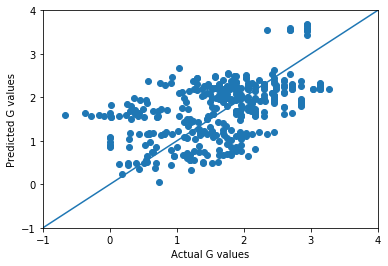

In [26]:
x = np.linspace(-4,4,10)

plt.scatter(Y['ΔΔG‡'], y_pred)
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')
plt.plot(x, x)

#does not show outlier

In [27]:
ridge_cvs = Ridge()

scores = cross_val_score(ridge_cvs, X, Y, cv = 4)
print(sum(np.abs(scores)))
scores

#lasso_cvs.get_params()

17.087666738988002


array([-5.76404296, -8.75420788, -2.07023924,  0.49917666])

In [28]:
predict_ridge_cvs = Ridge()

y_pred = cross_val_predict(predict_ridge_cvs, X, Y, cv = 4)

#for k in range(406):
 #   if y_pred[k] - Y.iloc[k,0] > 2 or y_pred[k] - Y.iloc[k,0] < -2:
  #      print(k, X.index[k], y_pred[k], Y.iloc[k, 0], y_pred[k] - Y.iloc[k,0])
   #     print(k, X.index[k], y_pred[k] - Y.iloc[k,0])
    
results = pd.concat([Y.reset_index(), pd.DataFrame(y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']
results['Residual'] = results['Actual'] - results['Predicted']

#results.head(406)
#print(predict_lasso_cvs.coef_)

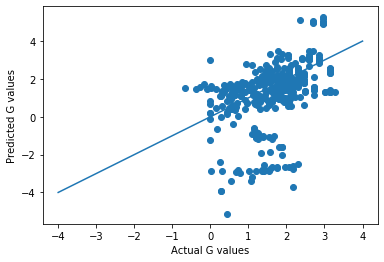

In [29]:
x = np.linspace(-4,4,10)

plt.scatter(Y['ΔΔG‡'], y_pred)
#plt.xlim(-1, 4)
#plt.ylim(-1, 4)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')
plt.plot(x, x)
#does not show outlier

In [30]:
tree_cvs = DecisionTreeRegressor()

scores = cross_val_score(tree_cvs, X, Y, cv = 4)
print(sum(np.abs(scores)))
scores

5.61409129649048


array([-0.25365918, -1.81190111, -3.28195374,  0.26657727])

In [31]:
predict_tree_cvs = DecisionTreeRegressor()

y_pred = cross_val_predict(predict_tree_cvs, X, Y, cv = 4)

#for k in range(406):
 #   if y_pred[k] - Y.iloc[k,0] > 2 or y_pred[k] - Y.iloc[k,0] < -2:
  #      print(k, X.index[k], y_pred[k], Y.iloc[k, 0], y_pred[k] - Y.iloc[k,0])
   #     print(k, X.index[k], y_pred[k] - Y.iloc[k,0])
        
results = pd.concat([Y.reset_index(), pd.DataFrame(y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']
results['Residual'] = results['Actual'] - results['Predicted']

#results.head(406)

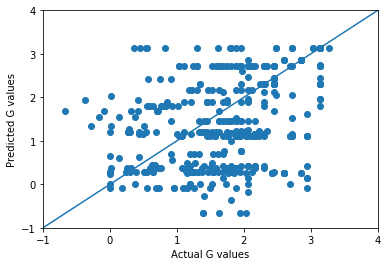

In [32]:
x = np.linspace(-4,4,10)

plt.scatter(Y['ΔΔG‡'], y_pred)
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')
plt.plot(x, x)
#does not show outlier

In [33]:
boosting_cvs = GradientBoostingRegressor()

scores = cross_val_score(boosting_cvs, X, Y.values.ravel(), cv = 4)
print(sum(np.abs(scores)))
scores


2.0532549554277466


array([ 0.24444105, -0.73795744, -0.52027977,  0.5505767 ])

In [34]:
predict_boosting_cvs = GradientBoostingRegressor()

y_pred = cross_val_predict(predict_boosting_cvs, X, Y.values.ravel(), cv = 4)

#for k in range(406):
 #   if y_pred[k] - Y.iloc[k,0] > 2 or y_pred[k] - Y.iloc[k,0] < -2:
  #      print(k, X.index[k], y_pred[k], Y.iloc[k, 0], y_pred[k] - Y.iloc[k,0])
   #     print(k, X.index[k], y_pred[k] - Y.iloc[k,0])
        
results = pd.concat([Y.reset_index(), pd.DataFrame(y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']
results['Residual'] = results['Actual'] - results['Predicted']

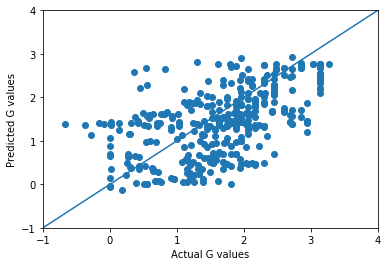

In [35]:
x = np.linspace(-4,4,10)

plt.scatter(Y['ΔΔG‡'], y_pred)
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')
plt.plot(x, x)
#does not show outlier

In [36]:
forest_cvs = RandomForestRegressor()

scores = cross_val_score(forest_cvs, X, Y.values.ravel(), cv = 4)
print(sum(np.abs(scores)))
scores

2.9634074169215454


array([-0.00157955, -0.97542209, -1.51941834,  0.46698744])

In [37]:
predict_forest_cvs = RandomForestRegressor()

y_pred = cross_val_predict(predict_forest_cvs, X, Y.values.ravel(), cv = 4)

#for k in range(406):
 #   if y_pred[k] - Y.iloc[k,0] > 2 or y_pred[k] - Y.iloc[k,0] < -2:
  #      print(k, X.index[k], y_pred[k], Y.iloc[k, 0], y_pred[k] - Y.iloc[k,0])
   #     print(k, X.index[k], y_pred[k] - Y.iloc[k,0])
    
results = pd.concat([Y.reset_index(), pd.DataFrame(y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']
results['Residual'] = results['Actual'] - results['Predicted']
print(mean_squared_error(results['Actual'], results['Predicted']))
print(r2_score(results['Actual'], results['Predicted']))

0.5154499831362367
0.24957960732170303


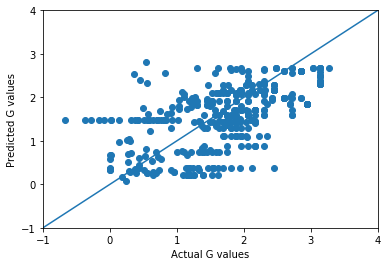

In [38]:
x = np.linspace(-4,4,10)

plt.scatter(Y['ΔΔG‡'], y_pred)
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')
plt.plot(x, x)
#does not show outlier

###############################################################################################################################

End of cross validation

Model development with train test split

###############################################################################################################################

In [1]:
model = LinearRegression()

X_train, X_test, Y_train, Y_test = train_test_split(X.loc[:, [
'B53',
'iPOsy',
'nPOas',
'iPOas',
'nXH',
'iXH',
'Polarizability',
'H-X-Nu',
'H-X-CNu',
'Schultz Molecular Topological',
'Schultz Molecular Topological by valence vertex degrees',
'Gutman Molecular Topological',
'Gutman MTI by valence vertex degrees',
'Centralization',
'ALOGP2',
'PEOE5',
'RMM',
'Z-iminium nNH',
'Z-iminium i NH'
]], Y, test_size = 0.1, random_state = 4)

model.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1))
Y_pred = model.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']

print(mean_squared_error(Y_test, Y_pred))
print(r2_score(Y_test, Y_pred))
results

#print(model.intercept_)
print(model.coef_)
#print(model.coef_.shape)

NameError: name 'LinearRegression' is not defined

Text(0, 0.5, 'Predicted G values')

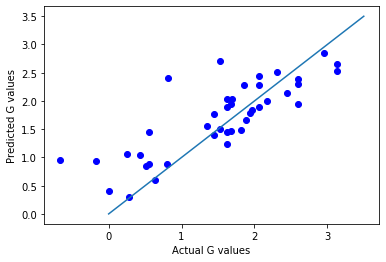

In [40]:
x = np.linspace(0,3.5,10)

plt.scatter(results['Actual'], results['Predicted'], color = 'b')
#plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.plot(x, x)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')

In [41]:
lasso_model = Lasso(alpha = 0.1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 3)

lasso_model.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1))
Y_pred = lasso_model.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']

print('MSE: ' + str(mean_squared_error(Y_test, Y_pred)))
print('r^2: ' + str(r2_score(Y_test, Y_pred)))
results.head()

Y_train_pred = lasso_model.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
train_results.set_index('Reaction', inplace = True)
train_results.columns = ['Actual', 'Predicted']

all_results = pd.concat([train_results, results])
all_results
print('Total r^2 score: ' + str(r2_score(all_results['Actual'], all_results['Predicted'])))

MSE: 0.198165185600555
r^2: 0.6075912539311663
Total r^2 score: 0.6427520133563508


C:\Users\jlisd\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.720662602559571, tolerance: 0.02578850847923468
  positive)


In [42]:
#print(len(lasso_model.coef_))
#print(lasso_model.coef_)

features = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(lasso_model.coef_), pd.DataFrame(np.abs(lasso_model.coef_))], axis = 1)
features.columns = ['Feature', 'Coefficient', 'Abs Val Coefficient']
features.set_index('Feature', inplace = True)

features.sort_values(by = ['Abs Val Coefficient'], ascending = False, inplace = True)

features.head(25)
#for i in range(299):
 #   if np.abs(features.iloc[i,0]) > 0.001:
  #      print(i, features.index[i])

,Coefficient,Abs Val Coefficient
Feature,,
B53,0.038524,0.038524
Centralization,0.033901,0.033901
PEOE5,0.015594,0.015594
RMM,0.007851,0.007851
Gutman MTI by valence vertex degrees,0.007323,0.007323
Schultz Molecular Topological,-0.007270,0.007270
H-X-CNu,-0.007236,0.007236
Gutman Molecular Topological,-0.004748,0.004748
Polarizability,0.004475,0.004475


Text(0, 0.5, 'Predicted G values')

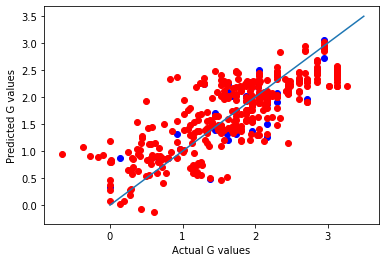

In [43]:
x = np.linspace(0,3.5,10)

plt.scatter(results['Actual'], results['Predicted'], color = 'b')
plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.plot(x, x)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')

In [44]:
ridge_model = Ridge()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 3)

ridge_model.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1))
Y_pred = ridge_model.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']

print('MSE: ' + str(mean_squared_error(Y_test, Y_pred)))
print('r^2: ' + str(r2_score(Y_test, Y_pred)))
results.head()

Y_train_pred = ridge_model.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
train_results.set_index('Reaction', inplace = True)
train_results.columns = ['Actual', 'Predicted']

all_results = pd.concat([train_results, results])
all_results
print('Total r^2 score: ' + str(r2_score(all_results['Actual'], all_results['Predicted'])))

MSE: 0.11768325297643308
r^2: 0.766962407681089
Total r^2 score: 0.7511070982098729


Text(0, 0.5, 'Predicted G values')

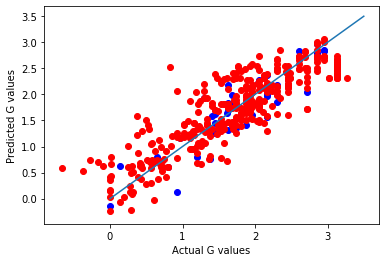

In [45]:
x = np.linspace(0,3.5,10)

plt.scatter(results['Actual'], results['Predicted'], color = 'b')
plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.plot(x, x)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')

In [46]:
tree_model = DecisionTreeRegressor()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 3)

tree_model.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1))
Y_pred = tree_model.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']

print('MSE: ' + str(mean_squared_error(Y_test, Y_pred)))
print('test r^2: ' + str(r2_score(Y_test, Y_pred)))
results.head()

Y_train_pred = tree_model.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
train_results.set_index('Reaction', inplace = True)
train_results.columns = ['Actual', 'Predicted']

all_results = pd.concat([train_results, results])
all_results
print('Total r^2 score: ' + str(r2_score(all_results['Actual'], all_results['Predicted'])))

MSE: 0.24247192078402033
test r^2: 0.51985459956851
Total r^2 score: 0.9462216632755042


In [47]:
tree_model.feature_importances_
features = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(tree_model.feature_importances_)], axis = 1)
features.columns = ['Feature', 'Importance']
features.set_index('Feature', inplace = True)
features.sort_values(by = ['Importance'], ascending = False, inplace = True)

features.head(25)
#for i in range(299):
 #   if np.abs(features.iloc[i,0]) > 0.01:
  #      print(i, features.index[i])

,Importance
Feature,
B5,0.402698
Z-iminium LUMO,0.109735
B1whole,0.059477
Average connectivity index chi-3,0.042232
iPOsy,0.032014
L6.2,0.028959
Z-iminium SB5,0.028667
HOMO,0.027373
Total structure connectivity,0.021327


Text(0, 0.5, 'Predicted G values')

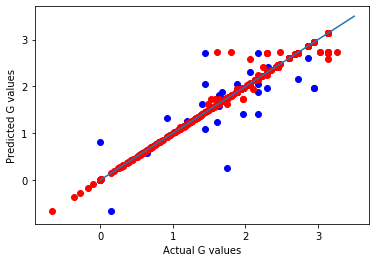

In [48]:
x = np.linspace(0,3.5,10)

plt.scatter(results['Actual'], results['Predicted'], color = 'b')
plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.plot(x, x)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')

In [49]:
boosting_tree = GradientBoostingRegressor()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 3)

boosting_tree.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = boosting_tree.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']

print('MSE: ' + str(mean_squared_error(Y_test, Y_pred)))
print('test r^2: ' + str(r2_score(Y_test, Y_pred)))
results.head()

Y_train_pred = boosting_tree.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
train_results.set_index('Reaction', inplace = True)
train_results.columns = ['Actual', 'Predicted']
train_results

all_results = pd.concat([train_results, results])
all_results
print('Total r^2 score: ' + str(r2_score(all_results['Actual'], all_results['Predicted'])))

MSE: 0.08433701332333737
test r^2: 0.8329949756557609
Total r^2 score: 0.9038171699458056


In [50]:
boosting_tree.feature_importances_
features = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(boosting_tree.feature_importances_)], axis = 1)
features.columns = ['Feature', 'Importance']
features.set_index('Feature', inplace = True)
features.sort_values(by = ['Importance'], ascending = False, inplace = True)

features.head(25)
#for i in range(299):
 #   if features.iloc[i,0] > 0.01:
  #      print(i, features.index[i])
        


,Importance
Feature,
B5,0.397273
Z-iminium LUMO,0.076987
Average connectivity index chi-3,0.030486
B1whole.2,0.029182
C2.2,0.025650
Z-iminium PG,0.023498
LUMO,0.021349
X,0.019601
E-iminium LL,0.018093


Text(0, 0.5, 'Predicted G values')

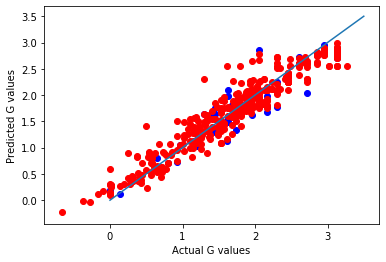

In [51]:
x = np.linspace(0,3.5,10)

plt.scatter(results['Actual'], results['Predicted'], color = 'b')
plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.plot(x, x)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')

In [52]:
forest = RandomForestRegressor()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 3)

forest.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = forest.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']

print('MSE: ' + str(mean_squared_error(Y_test, Y_pred)))
print('r^2: ' + str(r2_score(Y_test, Y_pred)))
results.head()

Y_train_pred = forest.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
train_results.set_index('Reaction', inplace = True)
train_results.columns = ['Actual', 'Predicted']
train_results

all_results = pd.concat([train_results, results])
all_results
print('Total r^2 score: ' + str(r2_score(all_results['Actual'], all_results['Predicted'])))

MSE: 0.1758937577635538
r^2: 0.7190372884142726
Total r^2 score: 0.8450673126758032


In [53]:
#testing less features
forest = RandomForestRegressor()
X_train, X_test, Y_train, Y_test = train_test_split(X.loc[:, ['B5', 'iXH', 'Nu', 'iPOas', 'X', 'HOMO', 'B1whole.2', 'B1whole.1',
       'nXH', 'Polarizability', 'C2', 'LUMO', 'iPOsy', 'H',
       'Balaban distance connectivity index', 'Mean Distance Degree Deviation',
       'L', 'Average eccentricity', 'B1whole', 'C2.2', 'Superpendentic',
       'B5whole.1', 'P', 'Maximal electrotopological positive variation',
       'Variation']], Y, test_size = 0.1, random_state = 3)

forest.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = forest.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']

print('MSE: ' + str(mean_squared_error(Y_test, Y_pred)))
print('r^2: ' + str(r2_score(Y_test, Y_pred)))
results.head()

Y_train_pred = forest.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
train_results.set_index('Reaction', inplace = True)
train_results.columns = ['Actual', 'Predicted']
train_results

all_results = pd.concat([train_results, results])
print(all_results)
print('Total r^2 score: ' + str(r2_score(all_results['Actual'], all_results['Predicted'])))

MSE: 0.07559138792472475
r^2: 0.8503131533460389
                                                     Actual  Predicted
Reaction                                                              
Transfer Hydrogenation of N-aryl imines (Ruepin...  0.72692   0.772114
Addition of thiols Catalyst & solvent screening...  0.55924   1.062406
Addition of thiols to imines (Denmark) 14            3.1343   2.935734
Addition of thiols Imine scope 6                    2.72089   2.647436
Addition of diazomethylphosphonates Imine scope 1   2.45065   2.248336
...                                                     ...        ...
Transfer Hydrogenation of N-aryl imines by benz...  2.94915   2.809448
Hydrogenation of fluorinated alkynyl ketimines 10   2.60253   2.662828
Addition of diazoacetamides Catalyst screening ...  1.30103   1.394562
Transfer Hydrogenation of b,g-Alkynyl a-Imino E...  2.16929   1.917177
Transfer Hydrogenation of N-aryl imines by benz...  2.03968   1.956290

[406 rows x 2 columns]
Tota

In [54]:
print(Y_pred)

[1.70365345 1.93974982 2.03092836 1.26468319 2.03092836 1.67270925
 1.82965857 0.74297995 0.18612615 1.70365345 1.82068808 2.03092836
 1.26468319 2.10810206 2.66282771 2.92446768 0.74297995 0.86376328
 1.2755288  2.10810206 1.89954991 1.82965857 2.93573416 2.66282771
 0.36195343 1.82965857 1.2755288  1.2755288  1.91717683 0.48240387
 1.91717683 2.80944779 2.24833616 2.45417108 1.54301031 1.82068808
 2.80944779 2.66282771 1.39456158 1.91717683 1.95628983]


In [55]:
forest.feature_importances_
features = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(forest.feature_importances_)], axis = 1)
features.columns = ['Feature', 'Importance']
features.set_index('Feature', inplace = True)
features.sort_values(by = ['Importance'], ascending = False, inplace = True)

features.head(25)
#for i in range(299):
    #if features.iloc[i,0] > 0.005:
        #print(i, features.index[i])
        
print(features.index[0:25])

Index(['arhs', 'alhs', 'C1', 'sin(AREA)', 'b', 'L6', 'L5', 'B53', 'C4',
       'B5whole', 'AREA(q)', 'B56', 'L3', 'C3', 'B1whole', 'B55', 'B16', 'C2',
       'B13', 'aavg', 'L2', 'B15', 'L4', 'B12', 'Lwhole'],
      dtype='object', name='Feature')


Text(0, 0.5, 'Predicted G values')

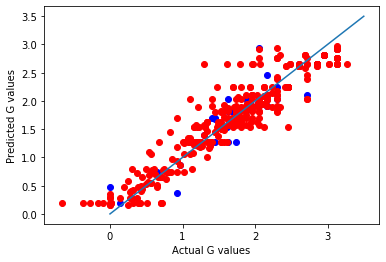

In [56]:
x = np.linspace(0,3.5,10)

plt.scatter(results['Actual'], results['Predicted'], color = 'b')
plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.plot(x, x)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')

###############################################################################################################################

End of train test split section

Replicating Paper models + extra

###############################################################################################################################

In [57]:
#50 50 TS VS Split

forest = RandomForestRegressor()

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.5, random_state = 15)

forest.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())
y_pred = cross_val_predict(forest, X_val, Y_val.values.ravel(), cv = 4)

results = pd.concat([Y_val.reset_index(), pd.DataFrame(y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']
results['Residual'] = results['Actual'] - results['Predicted']
results

print('MSE: ' + str(mean_squared_error(Y_val, y_pred)))
print('r^2: ' + str(r2_score(Y_val, y_pred)))

Y_train_pred = forest.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
train_results.set_index('Reaction', inplace = True)
train_results.columns = ['Actual', 'Predicted']
train_results

all_results = pd.concat([train_results, results])
all_results
print('Total r^2 score: ' + str(r2_score(all_results['Actual'], all_results['Predicted'])))

MSE: 0.21376160204065084
r^2: 0.6920434162664698
Total r^2 score: 0.817008720582098


Text(0, 0.5, 'Predicted G values')

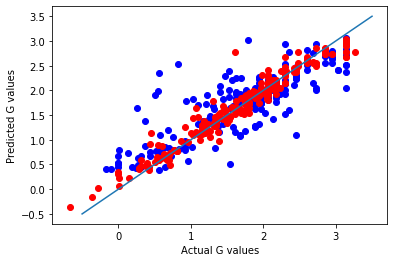

In [58]:
x = np.linspace(-0.5,3.5,10)

plt.scatter(results['Actual'], results['Predicted'], color = 'b')
plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.plot(x, x)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')

In [59]:
#Leave one out
forest = RandomForestRegressor()

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.1, random_state = 3)

forest.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())
y_pred = cross_val_predict(forest, X_val, Y_val.values.ravel(), cv = X_val.shape[0])

results = pd.concat([Y_val.reset_index(), pd.DataFrame(y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']
results['Residual'] = results['Actual'] - results['Predicted']
results

print('MSE: ' + str(mean_squared_error(Y_val, y_pred)))
print('r^2: ' + str(r2_score(Y_val, y_pred)))

Y_train_pred = forest.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
train_results.set_index('Reaction', inplace = True)
train_results.columns = ['Actual', 'Predicted']
train_results

all_results = pd.concat([train_results, results])
all_results
print('Total r^2 score: ' + str(r2_score(all_results['Actual'], all_results['Predicted'])))

MSE: 0.3058439983365875
r^2: 0.39436455744624677
Total r^2 score: 0.9106024991206411


Text(0, 0.5, 'Predicted G values')

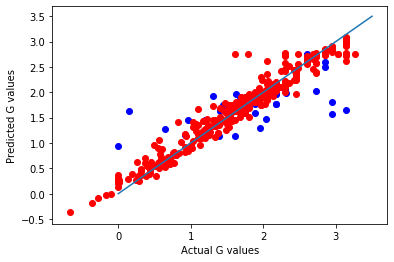

In [60]:
x = np.linspace(0,3.5,10)

plt.scatter(results['Actual'], results['Predicted'], color = 'b')
plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.plot(x, x)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values') 

Text(0, 0.5, 'Predicted G values')

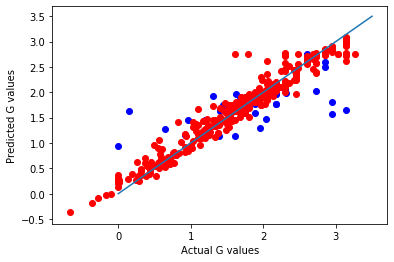

In [61]:
x = np.linspace(0,3.5,10)

plt.scatter(results['Actual'], results['Predicted'], color = 'b')
plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.plot(x, x)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')

In [62]:
boosting_tree = GradientBoostingRegressor()
X_train, X_test, Y_train, Y_test = train_test_split(X_no_iminium, Y, test_size = 0.5, random_state = 3)

boosting_tree.fit(X_train.reset_index().drop(['Reaction'], axis = 1), Y_train.reset_index().drop('Reaction', axis = 1).values.ravel())
Y_pred = boosting_tree.predict(X_test.reset_index().drop(['Reaction'], axis = 1))

results = pd.concat([Y_test.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']

print('MSE: ' + str(mean_squared_error(Y_test, Y_pred)))
print('test r^2: ' + str(r2_score(Y_test, Y_pred)))
results.head()

Y_train_pred = boosting_tree.predict(X_train.reset_index().drop(['Reaction'], axis = 1))
train_results = pd.concat([Y_train.reset_index(), pd.DataFrame(Y_train_pred)], axis = 1)
train_results.set_index('Reaction', inplace = True)
train_results.columns = ['Actual', 'Predicted']
train_results

all_results = pd.concat([train_results, results])
all_results
print('Total r^2 score: ' + str(r2_score(all_results['Actual'], all_results['Predicted'])))

MSE: 0.1610132216842387
test r^2: 0.7428066126919073
Total r^2 score: 0.8283734584335658


In [63]:
boosting_tree.feature_importances_
features = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(boosting_tree.feature_importances_)], axis = 1)
features.columns = ['Feature', 'Importance']
features.set_index('Feature', inplace = True)
features.sort_values(by = ['Importance'], ascending = False, inplace = True)

features.head(25)

,Importance
Feature,
B5,0.410121
iXH,0.085810
iPOas,0.041463
Nu,0.029537
Wiener-type index from polarizability weighted distance matrix,0.026433
LUMO,0.023265
C2.2,0.021780
B1whole.1,0.019118
Wiener-type index from van der waals weighted distance matrix,0.018150


Text(0, 0.5, 'Predicted G values')

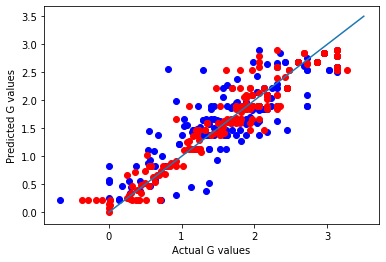

In [64]:
x = np.linspace(0,3.5,10)

plt.scatter(results['Actual'], results['Predicted'], color = 'b')
plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.plot(x, x)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')

Text(0, 0.5, 'Predicted G values')

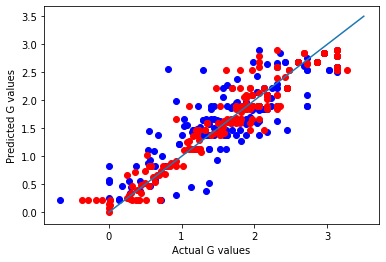

In [65]:
x = np.linspace(0,3.5,10)

plt.scatter(results['Actual'], results['Predicted'], color = 'b')
plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.plot(x, x)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')

In [66]:
#scaler = MinMaxScaler(feature_range = (0,1))
#X = scaler.fit_transform(X)
scores = []
forest_test = RandomForestRegressor()
cv = KFold(n_splits = 4, random_state = 3, shuffle = True)
for train_index, test_index in cv.split(X):
    print('Train Index: ', train_index, "\n")
    print('Test Index: ', test_index)
    
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    Y_train, Y_test = np.array(Y.values.ravel())[train_index], np.array(Y.values.ravel())[test_index]
    forest_test.fit(X_train, Y_train)
    scores.append(forest_test.score(X_test, Y_test))

Train Index:  [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  17  18  19  20
  21  22  25  26  28  29  30  32  33  34  35  36  38  39  41  42  43  44
  45  46  47  48  49  50  52  54  57  58  59  60  62  63  64  65  68  69
  70  71  72  75  76  77  78  79  80  85  86  87  89  90  91  92  93  94
  95  96  97  99 100 104 106 108 109 110 111 113 115 117 118 119 120 121
 122 125 126 129 131 132 133 134 135 138 139 140 141 143 145 146 147 148
 149 150 151 152 156 158 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 187 189 192 195 196
 198 199 200 201 202 204 205 206 207 208 210 211 212 213 215 216 217 219
 220 221 222 223 224 225 226 229 231 232 233 234 235 236 237 239 241 242
 243 245 246 247 248 249 250 252 253 254 256 257 258 259 261 262 263 264
 266 267 270 272 274 275 276 277 280 282 283 285 286 287 288 289 291 292
 293 295 296 297 300 302 303 304 305 306 307 308 309 310 311 312 313 314
 315 316 317 318 320 322 323 324 326 

In [67]:
Y_pred = forest_test.predict(X.reset_index().drop(['Reaction'], axis = 1))
Y_pred
results = pd.concat([Y.reset_index(), pd.DataFrame(Y_pred)], axis = 1)
results.set_index('Reaction', inplace = True)
results.columns = ['Actual', 'Predicted']

print('MSE: ' + str(mean_squared_error(Y, Y_pred)))
print('r^2: ' + str(r2_score(Y, Y_pred)))
results.head()
#results.set_index('Reaction', inplace = True)
#results.columns = ['Actual', 'Predicted']

#print('MSE: ' + str(mean_squared_error(Y, Y_pred)))
#print('r^2: ' + str(r2_score(Y, Y_pred)))
#results

MSE: 0.06279058592740291
r^2: 0.9085860167043829


,Actual,Predicted
Reaction,,
Addition of Alcohols Scope 1,2.05829,1.777151
Addition of Alcohols Scope 2,1.74348,1.570203
Addition of Alcohols Scope 3,1.62926,1.583393
Addition of Alcohols Scope 4,1.88181,1.791512
Addition of Alcohols Scope 5,1.88181,1.876215


Text(0, 0.5, 'Predicted G values')

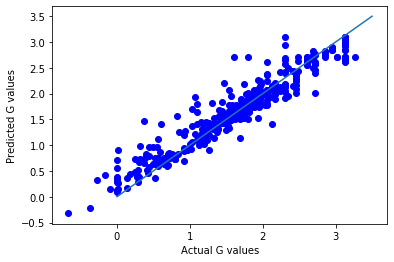

In [68]:
x = np.linspace(0,3.5,10)

plt.scatter(results['Actual'], results['Predicted'], color = 'b')
#plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.plot(x, x)
plt.xlabel('Actual G values')
plt.ylabel('Predicted G values')

Text(0, 0.5, 'G Values')

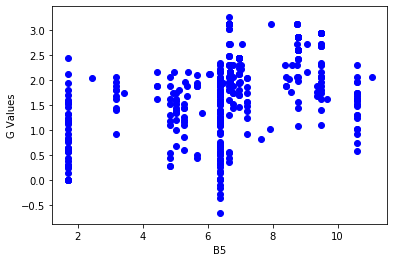

In [69]:
plt.scatter(X.loc[:, 'B5'], Y, color = 'b')
#plt.scatter(train_results['Actual'], train_results['Predicted'], color = 'r')
#plt.xlim(0, 4)
#plt.ylim(-1, 3)
plt.xlabel('B5')
plt.ylabel('G Values')

###############################################################################################################################

Notes

###############################################################################################################################

In [ ]:
5/23
##given properties of iminium and catalyst, build model to predict delta delta G
##use scikit learn
##use linear regression to debug pipeline I built up, make sure I load info correct

In [ ]:
5/30
#now include all numerical properties
#run linear regression multiple times (cross validation look it up)
#try lasso linear regression
#use regression tree scikit learn
#use boosting tree

In [ ]:
6/20
#try cross val predict with all models, look at specific reactions taht are causing it.

6/22
#take a look at supplementary material and read stuff from s594 to end, try to replicate what they are doing (LOO)

#notice: in the paper, some actual Gs are negative. In our data, it doesnt' seem like this is the case
#graph of actual vs predicted doesnt' show good prediction

In [ ]:
6/24
#figure out cross val predict, why it is doing that
#boosting, random forest might tell you which features are more important
#do leave one out
#try to replicate paper
#try to use thier equation

#notes: They did not use out of sample reactions
#for linear regression, I probably need less features
#I'm sturggling because I'm using all 299 features on only 300-400 data points
#need to choose most important and develop model based off of that

In [ ]:
6/26
#try removing e and z
#try to figure out e and z
#try replciating some of the models
#do cross validation manually

6/28
#use b5, other important figures to figure this thing out
#do cross validation manually
#which experiments/reactions cannot be well predicted, take a look at those experiments

6/30
#turn z imines negative in new jupyter notebook 
#figure out important feature in iminium prediction, put all in new spreadsheet, identify them (nucleophile, catalyst, solven, iminium, etc)
#csend email to  sigman making sure they made z reaction delta g negative
#write email to dakang about all missing data, cc 
#read other stereochemistry paper 
#https://pubs.acs.org/doi/10.1021/acs.accounts.6b00052

7/2
#ask sigman about missing data in reactions 7, 12, 15
#try to build model without iminium data with negative z values still

In [ ]:
#model notes
#svm doesn't work